## This notebook will construct the nodes and edges that we will build our graph with

Import relevant libraries and import raw data

In [2]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

In [223]:
df = pd.read_csv("../../data/current_clean_spectrum.csv")

In [224]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))

In [5]:
#sns.lineplot(data=df, x='WaveNumber', y='Absorbance', hue='Status', errorbar=('ci', False))

Here we use scipy's function "find_peaks" to find all peaks in each individual spectra sample as well as pulling featurse such as prominence and width of peaks

In [225]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,0.203556
1,201210-1-00,294,400.91116,201210-1,Normal,0.203010
2,201210-1-00,295,401.59454,201210-1,Normal,0.202464
3,201210-1-00,296,402.27789,201210-1,Normal,0.201917
4,201210-1-00,297,402.96127,201210-1,Normal,0.201370
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-0.078901
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-0.074710
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-0.070333
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-0.065772


In [226]:
# Assuming 'df' is your DataFrame
# Step 1: Group by 'SurID'
groups = df.groupby('SurID')

In [227]:
print(groups['Absorbance'])

In [228]:
# Assuming 'df' is your DataFrame
# Function to identify samples where at least 25% of values are outliers
def identify_outliers(group):
    Q1 = group['Absorbance'].quantile(0.25)
    Q3 = group['Absorbance'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Determine if a measurement is an outlier
    is_outlier = (group['Absorbance'] < lower_bound) | (group['Absorbance'] > upper_bound)
    outlier_prop = is_outlier.mean()  # Proportion of measurements that are outliers
    
    # Return the SpecID if outlier proportion is >= 0.25
    if outlier_prop >= 0.04:
        return group['SpecID'].iloc[0]
    return pd.NA  # Use pandas NA for non-outliers or when the condition is not met

# Apply the function to each 'SpecID' group within each 'SurID' and flatten the result
outlier_specids = df.groupby('SurID').apply(lambda x: x.groupby('SpecID').apply(identify_outliers)).dropna()

# Convert to a flat list of unique SpecIDs
outlier_specids = pd.Series(outlier_specids.values.flatten()).dropna().unique()

# Remove samples (SpecID) where ≥ 25% of 'Absorbance' values are outliers
clean_df = df[~df['SpecID'].isin(outlier_specids)]

In [229]:
print(clean_df['SpecID'].nunique())

2065


In [230]:
df = clean_df

In [231]:
df = df.groupby(["SpecID", "WaveNumber", "Status", "SurID"])["Absorbance"].median().reset_index()

In [232]:
pivoted_df = df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
pivoted_df.columns.name = None
statuses = df[['SpecID', 'Status']].drop_duplicates()
pivoted_df = pd.merge(pivoted_df, statuses, on='SpecID')
pivoted_df = pivoted_df.set_index('SpecID')

In [79]:
pivoted_df = df.pivot(index='SurID', columns='WaveNumber', values='Absorbance').reset_index()
pivoted_df.columns.name = None
statuses = df[['SurID', 'Status']].drop_duplicates()
pivoted_df = pd.merge(pivoted_df, statuses, on='SurID')
pivoted_df = pivoted_df.set_index('SurID')

In [213]:
pivoted_df

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.203556,0.203010,0.202464,0.201917,0.201370,0.200822,0.200273,0.199724,0.199174,0.198624,...,-0.075285,-0.080143,-0.085290,-0.090727,-0.096452,-0.102466,-0.108769,-0.115361,-0.122242,Normal
201210-1-01,0.207050,0.212595,0.217953,0.223125,0.228109,0.232907,0.237518,0.241943,0.246181,0.250232,...,-0.072436,-0.071108,-0.069651,-0.068065,-0.066350,-0.064505,-0.062531,-0.060428,-0.058195,Normal
201210-1-05,0.499901,0.494222,0.488921,0.483997,0.479451,0.475281,0.471489,0.468074,0.465036,0.462376,...,-0.165273,-0.165654,-0.165905,-0.166024,-0.166013,-0.165872,-0.165600,-0.165197,-0.164664,Normal
201210-1-10,0.089658,0.088674,0.088423,0.088906,0.090124,0.092075,0.094759,0.098178,0.102330,0.107216,...,-0.139571,-0.139367,-0.138950,-0.138322,-0.137482,-0.136430,-0.135166,-0.133690,-0.132002,Normal
201210-1-12,0.095981,0.094277,0.092913,0.091889,0.091205,0.090861,0.090856,0.091191,0.091866,0.092881,...,-0.132303,-0.134703,-0.137284,-0.140048,-0.142993,-0.146120,-0.149429,-0.152919,-0.156592,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,-0.009309,-0.009209,-0.009153,-0.009140,-0.009172,-0.009247,-0.009367,-0.009530,-0.009737,-0.009989,...,-0.208941,-0.204031,-0.199054,-0.194012,-0.188903,-0.183729,-0.178489,-0.173182,-0.167810,Hyperglycemia
210526-3-46,0.008168,-0.007448,-0.022068,-0.035692,-0.048320,-0.059951,-0.070587,-0.080226,-0.088869,-0.096515,...,-0.214451,-0.214824,-0.215151,-0.215431,-0.215664,-0.215850,-0.215989,-0.216081,-0.216126,Hyperglycemia
210526-3-47,0.094002,0.083090,0.072727,0.062912,0.053645,0.044925,0.036754,0.029131,0.022056,0.015529,...,-0.225522,-0.218086,-0.210190,-0.201834,-0.193018,-0.183743,-0.174007,-0.163812,-0.153157,Hyperglycemia


In [30]:
import pandas as pd
from scipy.spatial.distance import pdist, squareform

# Drop the 'Status' column as it is not numeric
X = pivoted_df.drop(columns=['Status'])

# Calculate pairwise Euclidean distances
distances = pdist(X.values, metric='euclidean')

# Convert the condensed distances to a square matrix form
distance_matrix = squareform(distances)

In [49]:
import numpy as np

def gaussian_kernel(distances, sigma):
    return np.exp(-distances**2 / (2 * sigma**2))

# Sigma is the bandwidth parameter
sigma = 4 # Adjust sigma as needed
kernel_matrix = gaussian_kernel(distance_matrix, sigma)
kernel_matrix
# Convert the kernel matrix to a DataFrame
kernel_df = pd.DataFrame(kernel_matrix, index=pivoted_df.index, columns=pivoted_df.index)

In [50]:
kernel_df

SurID,201210-1,201210-2,210114-1,210114-2,210120-1,210120-2,210121-1,210121-2,210211-1,210211-2,...,210510-2,210511-1,210518-1,210519-1,210519-2,210519-3,210524-1,210526-1,210526-2,210526-3
SurID,,,,,,,,,,,,,,,,,,,,,
201210-1,1.000000,0.145315,0.003539,0.030244,0.056418,0.052258,0.015403,0.033065,0.017834,0.016881,...,0.011353,0.008509,0.022706,0.002866,0.015511,0.012208,0.018252,0.065931,0.010642,0.039915
201210-2,0.145315,1.000000,0.060382,0.120208,0.109648,0.385929,0.072694,0.042834,0.074367,0.084468,...,0.084267,0.055642,0.359579,0.032929,0.059487,0.103397,0.304239,0.536036,0.096637,0.575863
210114-1,0.003539,0.060382,1.000000,0.453006,0.073884,0.218927,0.053553,0.026377,0.053098,0.068120,...,0.117923,0.123764,0.076566,0.243752,0.120872,0.216193,0.147740,0.042179,0.001353,0.120129
210114-2,0.030244,0.120208,0.453006,1.000000,0.459350,0.225586,0.270495,0.243892,0.258373,0.310535,...,0.380624,0.266260,0.054585,0.223915,0.347730,0.315634,0.152388,0.049213,0.000962,0.137928
210120-1,0.056418,0.109648,0.073884,0.459350,1.000000,0.088249,0.503432,0.606254,0.489582,0.532847,...,0.428385,0.166159,0.021530,0.063061,0.246969,0.130912,0.074678,0.028723,0.000401,0.078185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210519-3,0.012208,0.103397,0.216193,0.315634,0.130912,0.353926,0.117427,0.059574,0.088053,0.125791,...,0.190136,0.177239,0.075470,0.125270,0.408846,1.000000,0.153980,0.076868,0.003245,0.206498
210524-1,0.018252,0.304239,0.147740,0.152388,0.074678,0.322775,0.047974,0.022506,0.060713,0.067189,...,0.065851,0.040876,0.558130,0.092297,0.053278,0.153980,1.000000,0.435543,0.046288,0.612964
210526-1,0.065931,0.536036,0.042179,0.049213,0.028723,0.267882,0.015318,0.007735,0.020766,0.020586,...,0.017441,0.011577,0.666361,0.019497,0.016256,0.076868,0.435543,1.000000,0.319294,0.650159


In [55]:
from sklearn.preprocessing import LabelEncoder

# Example labels
labels = pivoted_df['Status']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
encoded_labels = label_encoder.fit_transform(labels)

# encoded_labels now contains numerical labels.
encoded_labels

array([2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 1, 1, 2, 2,
       2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [ ]:
import torch
from torch_geometric.data import Data

gaussian_kernel_matrix = torch.tensor(kernel_matrix)
edge_index = torch.nonzero(gaussian_kernel_matrix).t().contiguous()
edge_weight = gaussian_kernel_matrix[edge_index[0], edge_index[1]]

# Using an identity matrix for node features
num_nodes = gaussian_kernel_matrix.shape[0]  # Assuming square matrix
node_features = torch.eye(num_nodes)

# Converting labels to a tensor
labels = torch.tensor(encoded_labels, dtype=torch.long)

# Creating PyTorch Geometric data object
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_weight, y=labels)

In [117]:
status_df = pivoted_df['Status']

In [ ]:
status_df = status_df.reset_index()

In [214]:
status_df.to_csv('../../data/graph_2_6/status.csv')

In [120]:
from pycaret.classification import *

In [233]:
surface = df.groupby(['SurID', 'SpecID']).first().reset_index()

In [234]:
surface.drop(columns=['WaveNumber', 'Status', 'Absorbance'], inplace=True)

In [235]:
pivoted_df.reset_index(inplace=True)

In [236]:
pivoted_df = pd.merge(pivoted_df, surface, on='SpecID', how='left')

In [237]:
pivoted_df

,SpecID,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status,SurID
0,201210-1-00,0.203556,0.203010,0.202464,0.201917,0.201370,0.200822,0.200273,0.199724,0.199174,...,-0.080143,-0.085290,-0.090727,-0.096452,-0.102466,-0.108769,-0.115361,-0.122242,Normal,201210-1
1,201210-1-01,0.207050,0.212595,0.217953,0.223125,0.228109,0.232907,0.237518,0.241943,0.246181,...,-0.071108,-0.069651,-0.068065,-0.066350,-0.064505,-0.062531,-0.060428,-0.058195,Normal,201210-1
2,201210-1-05,0.499901,0.494222,0.488921,0.483997,0.479451,0.475281,0.471489,0.468074,0.465036,...,-0.165654,-0.165905,-0.166024,-0.166013,-0.165872,-0.165600,-0.165197,-0.164664,Normal,201210-1
3,201210-1-10,0.089658,0.088674,0.088423,0.088906,0.090124,0.092075,0.094759,0.098178,0.102330,...,-0.139367,-0.138950,-0.138322,-0.137482,-0.136430,-0.135166,-0.133690,-0.132002,Normal,201210-1
4,201210-1-11,-0.027146,-0.024271,-0.021382,-0.018480,-0.015564,-0.012634,-0.009691,-0.006735,-0.003765,...,-0.066071,-0.067065,-0.068063,-0.069065,-0.070071,-0.071081,-0.072095,-0.073112,Normal,201210-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060,210526-3-45,-0.009309,-0.009209,-0.009153,-0.009140,-0.009172,-0.009247,-0.009367,-0.009530,-0.009737,...,-0.204031,-0.199054,-0.194012,-0.188903,-0.183729,-0.178489,-0.173182,-0.167810,Hyperglycemia,210526-3
2061,210526-3-46,0.008168,-0.007448,-0.022068,-0.035692,-0.048320,-0.059951,-0.070587,-0.080226,-0.088869,...,-0.214824,-0.215151,-0.215431,-0.215664,-0.215850,-0.215989,-0.216081,-0.216126,Hyperglycemia,210526-3
2062,210526-3-47,0.094002,0.083090,0.072727,0.062912,0.053645,0.044925,0.036754,0.029131,0.022056,...,-0.218086,-0.210190,-0.201834,-0.193018,-0.183743,-0.174007,-0.163812,-0.153157,Hyperglycemia,210526-3
2063,210526-3-48,-0.057456,-0.061159,-0.064344,-0.067009,-0.069154,-0.070781,-0.071888,-0.072476,-0.072544,...,-0.133755,-0.121894,-0.109314,-0.096016,-0.082000,-0.067265,-0.051811,-0.035638,Hyperglycemia,210526-3


In [238]:
caret = setup(data=pivoted_df, target='Status', session_id=1234, fold_strategy='groupkfold', fold_groups='SurID')

,Description,Value
0,Session id,1234
1,Target,Status
2,Target type,Multiclass
3,Target mapping,"Hyperglycemia: 0, Hypoglycemia: 1, Normal: 2"
4,Original data shape,"(2065, 2052)"
5,Transformed data shape,"(2065, 2052)"
6,Transformed train set shape,"(1445, 2052)"
7,Transformed test set shape,"(620, 2052)"
8,Numeric features,2049
9,Categorical features,2


In [239]:
compare_models(exclude=['lightgbm', 'gbc'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.6254,0.0000,0.6254,0.6740,0.6166,0.4135,0.4402,0.6410
rf,Random Forest Classifier,0.5961,0.0000,0.5961,0.6455,0.5842,0.3594,0.3876,1.0190
knn,K Neighbors Classifier,0.5847,0.0000,0.5847,0.6062,0.5702,0.3502,0.3738,0.5140
ridge,Ridge Classifier,0.4490,0.0000,0.4490,0.4271,0.4077,0.1263,0.1365,0.5300
svm,SVM - Linear Kernel,0.4397,0.0000,0.4397,0.4865,0.3990,0.1495,0.1737,0.5820
lr,Logistic Regression,0.4320,0.0000,0.4320,0.5388,0.3691,0.1335,0.1839,1.0290
nb,Naive Bayes,0.3472,0.0000,0.3472,0.1373,0.1927,0.0000,0.0000,0.5100
dt,Decision Tree Classifier,0.3472,0.0000,0.3472,0.1373,0.1927,0.0000,0.0000,0.6000
qda,Quadratic Discriminant Analysis,0.3472,0.0000,0.3472,0.1373,0.1927,0.0000,0.0000,0.7400
ada,Ada Boost Classifier,0.3472,0.0000,0.3472,0.1373,0.1927,0.0000,0.0000,3.9720


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=1234, verbose=0,
                     warm_start=False)

In [16]:
peaks = []
widths = []
prom = []

for _, group in df.groupby('SurID'):
    peak_index, weights = find_peaks(x=group['Absorbance'], distance=10, width=10)
    peaks += list(group.iloc[peak_index].index.values)
    widths += list(weights['widths'])
    prom += list(weights['prominences'])

In [17]:
weights['widths']

array([ 89.69796135,  21.02022454,  15.63748991,  11.51573362,
        10.3974725 ,  47.83444497,  95.90962193, 102.94094506,
        50.08310562,  16.2250828 ,  76.98159764,  23.7075836 ,
        47.54346318,  32.07622249,  11.99539652,  78.49747364,
        16.48157671, 207.62051131,  10.76839069])

In [18]:
print(len(peaks))

1142


Below shows a scatterplot of the coordinates of all the peaks we have found

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

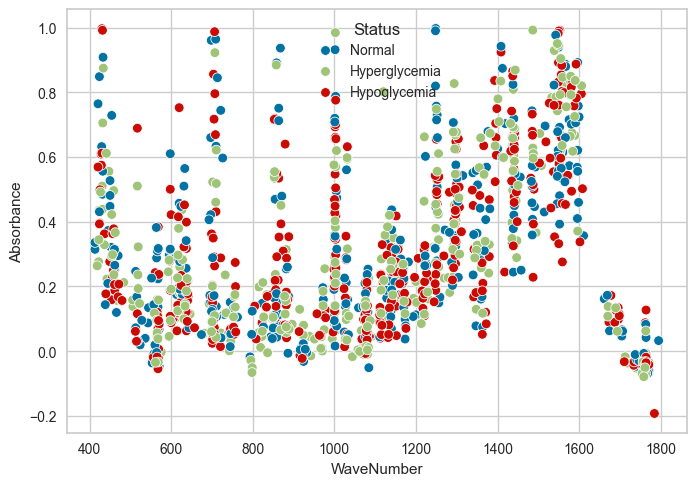

In [19]:
sns.scatterplot(data=df.iloc[peaks].reset_index(), x="WaveNumber", y="Absorbance", hue="Status")

We then add the peak information to our main dataframe

In [20]:
peak_df = df.iloc[peaks]
peak_df['Widths'] = widths
peak_df['Prominences'] = prom

In [21]:
peak_df

,WaveNumber,Status,SurID,Absorbance,Widths,Prominences
6467,469.93167,Normal,201210-1,0.295378,73.973526,0.242838
15476,567.65375,Normal,201210-1,0.223674,14.026237,0.030748
20264,619.58997,Normal,201210-1,0.457190,69.527171,0.330873
27509,698.17767,Normal,201210-1,0.960494,67.260943,0.985178
41936,854.66968,Normal,201210-1,0.469561,14.423201,0.015300
...,...,...,...,...,...,...
93510,1414.35080,Hyperglycemia,210526-3,0.598462,11.995397,0.028293
95589,1436.90210,Hyperglycemia,210526-3,0.658121,78.497474,0.285615
100188,1486.78820,Hyperglycemia,210526-3,0.596577,16.481577,0.117718
106425,1554.44190,Hyperglycemia,210526-3,0.904158,207.620511,0.982393


In [22]:
peaks = [[407, 495], [453,454], [516,537], 519, [603,738], [620, 624], [821, 839], [866, 887], 972, [1000, 1003], [1030, 1036], [1060, 1078], [1132, 1152], 1170, [1188, 1196], [1212-1294], [1427, 1446], [1448, 1450], [1520, 1533], [1542, 1594], [1611, 1653], 1668]

In [23]:
# Peaks list, corrected format
peaks_corrected = [[407, 495], [453, 454], [516, 537], [519, 519], [603, 738], [620, 624], [821, 839], [866, 887], [972, 972], 
         [1000, 1003], [1030, 1036], [1060, 1078], [1132, 1152], [1170, 1170], [1188, 1196], [1212, 1294], 
         [1427, 1446], [1448, 1450], [1520, 1533], [1542, 1594], [1611, 1653], [1668, 1668]]

# Convert peaks to a more efficient structure for processing
peak_ranges = [(peak[0], peak[1]) for peak in peaks_corrected]

# Create a function to determine the peak range for each WaveNumber
def find_peak_range(wavenumber):
    for start, end in peak_ranges:
        if start <= wavenumber <= end:
            return f"{start}-{end}"
    return None

# Apply the function to create a new column for peak range
peak_df['PeakRange'] = peak_df['WaveNumber'].apply(find_peak_range)

# Now, group by both SpecID and the new PeakRange column, and compute max Absorbance for each group
grouped = peak_df.groupby(['SurID', 'PeakRange'])['Absorbance'].max().reset_index()

# Pivot the table to have SpecID as rows and PeakRange as columns, filled with max Absorbance values
efficient_pivot_df = grouped.pivot(index='SurID', columns='PeakRange', values='Absorbance').reset_index()

# Fill NaN values with an appropriate placeholder if needed (e.g., 0 or empty string), here we keep NaNs
efficient_pivot_df

PeakRange,SurID,1000-1003,1030-1036,1060-1078,1132-1152,1188-1196,1212-1294,1427-1446,1448-1450,1520-1533,1542-1594,407-495,516-537,603-738,821-839,866-887
0,201210-1,NaN,NaN,NaN,0.087231,NaN,0.279230,0.333848,NaN,NaN,0.392664,0.295378,NaN,0.960494,NaN,0.479237
1,201210-2,NaN,NaN,NaN,0.183158,NaN,0.507239,0.635203,NaN,NaN,0.887520,0.229211,NaN,0.633354,NaN,NaN
2,210114-1,NaN,NaN,NaN,0.343212,NaN,0.819568,0.554622,NaN,NaN,0.715258,0.372932,NaN,0.267060,NaN,0.047185
3,210114-2,NaN,NaN,NaN,NaN,NaN,0.532867,0.454209,NaN,NaN,0.615240,0.314748,NaN,0.175106,NaN,-0.006132
4,210120-1,NaN,NaN,0.063625,0.110998,NaN,0.321952,NaN,NaN,NaN,0.666833,0.223109,NaN,0.119592,0.045332,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,210519-3,0.402753,0.108629,NaN,NaN,NaN,0.114548,0.557734,NaN,NaN,0.849738,0.344593,NaN,0.297029,NaN,0.074993
59,210524-1,0.504524,NaN,NaN,0.417898,NaN,0.542800,0.741770,NaN,NaN,0.883116,0.207230,0.689040,0.349613,NaN,NaN
60,210526-1,NaN,NaN,NaN,0.253525,NaN,0.555995,NaN,NaN,NaN,0.945225,0.236481,0.193717,0.621405,NaN,NaN
61,210526-2,0.984194,NaN,NaN,0.420138,NaN,0.677248,NaN,NaN,NaN,0.950521,0.422359,0.322463,0.922367,NaN,NaN


In [24]:
# Replace all NaN values with 0
efficient_pivot_df_filled = efficient_pivot_df.fillna(0)

efficient_pivot_df_filled

PeakRange,SurID,1000-1003,1030-1036,1060-1078,1132-1152,1188-1196,1212-1294,1427-1446,1448-1450,1520-1533,1542-1594,407-495,516-537,603-738,821-839,866-887
0,201210-1,0.000000,0.000000,0.000000,0.087231,0.0,0.279230,0.333848,0.0,0.0,0.392664,0.295378,0.000000,0.960494,0.000000,0.479237
1,201210-2,0.000000,0.000000,0.000000,0.183158,0.0,0.507239,0.635203,0.0,0.0,0.887520,0.229211,0.000000,0.633354,0.000000,0.000000
2,210114-1,0.000000,0.000000,0.000000,0.343212,0.0,0.819568,0.554622,0.0,0.0,0.715258,0.372932,0.000000,0.267060,0.000000,0.047185
3,210114-2,0.000000,0.000000,0.000000,0.000000,0.0,0.532867,0.454209,0.0,0.0,0.615240,0.314748,0.000000,0.175106,0.000000,-0.006132
4,210120-1,0.000000,0.000000,0.063625,0.110998,0.0,0.321952,0.000000,0.0,0.0,0.666833,0.223109,0.000000,0.119592,0.045332,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,210519-3,0.402753,0.108629,0.000000,0.000000,0.0,0.114548,0.557734,0.0,0.0,0.849738,0.344593,0.000000,0.297029,0.000000,0.074993
59,210524-1,0.504524,0.000000,0.000000,0.417898,0.0,0.542800,0.741770,0.0,0.0,0.883116,0.207230,0.689040,0.349613,0.000000,0.000000
60,210526-1,0.000000,0.000000,0.000000,0.253525,0.0,0.555995,0.000000,0.0,0.0,0.945225,0.236481,0.193717,0.621405,0.000000,0.000000
61,210526-2,0.984194,0.000000,0.000000,0.420138,0.0,0.677248,0.000000,0.0,0.0,0.950521,0.422359,0.322463,0.922367,0.000000,0.000000


In [25]:
# Add back "Status" and "SurID" columns by joining on "SpecID"
# First, create a DataFrame with unique SpecID, Status, and SurID
status_surid_df = peak_df[['Status', 'SurID']].drop_duplicates()

# Merge this back into the efficient pivot table
pivot_df_with_status_surid = efficient_pivot_df_filled.merge(status_surid_df, on='SurID', how='left')

pivot_df_with_status_surid

,SurID,1000-1003,1030-1036,1060-1078,1132-1152,1188-1196,1212-1294,1427-1446,1448-1450,1520-1533,1542-1594,407-495,516-537,603-738,821-839,866-887,Status
0,201210-1,0.000000,0.000000,0.000000,0.087231,0.0,0.279230,0.333848,0.0,0.0,0.392664,0.295378,0.000000,0.960494,0.000000,0.479237,Normal
1,201210-2,0.000000,0.000000,0.000000,0.183158,0.0,0.507239,0.635203,0.0,0.0,0.887520,0.229211,0.000000,0.633354,0.000000,0.000000,Normal
2,210114-1,0.000000,0.000000,0.000000,0.343212,0.0,0.819568,0.554622,0.0,0.0,0.715258,0.372932,0.000000,0.267060,0.000000,0.047185,Normal
3,210114-2,0.000000,0.000000,0.000000,0.000000,0.0,0.532867,0.454209,0.0,0.0,0.615240,0.314748,0.000000,0.175106,0.000000,-0.006132,Normal
4,210120-1,0.000000,0.000000,0.063625,0.110998,0.0,0.321952,0.000000,0.0,0.0,0.666833,0.223109,0.000000,0.119592,0.045332,0.000000,Hyperglycemia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,210519-3,0.402753,0.108629,0.000000,0.000000,0.0,0.114548,0.557734,0.0,0.0,0.849738,0.344593,0.000000,0.297029,0.000000,0.074993,Hyperglycemia
59,210524-1,0.504524,0.000000,0.000000,0.417898,0.0,0.542800,0.741770,0.0,0.0,0.883116,0.207230,0.689040,0.349613,0.000000,0.000000,Hypoglycemia
60,210526-1,0.000000,0.000000,0.000000,0.253525,0.0,0.555995,0.000000,0.0,0.0,0.945225,0.236481,0.193717,0.621405,0.000000,0.000000,Hyperglycemia
61,210526-2,0.984194,0.000000,0.000000,0.420138,0.0,0.677248,0.000000,0.0,0.0,0.950521,0.422359,0.322463,0.922367,0.000000,0.000000,Hyperglycemia


In [26]:
caret = setup(data=pivot_df_with_status_surid, target='Status', session_id=1234)

,Description,Value
0,Session id,1234
1,Target,Status
2,Target type,Multiclass
3,Target mapping,"Hyperglycemia: 0, Hypoglycemia: 1, Normal: 2"
4,Original data shape,"(63, 17)"
5,Transformed data shape,"(63, 17)"
6,Transformed train set shape,"(44, 17)"
7,Transformed test set shape,"(19, 17)"
8,Numeric features,15
9,Categorical features,1


In [27]:
compare_models(exclude=['lightgbm', 'gbc'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.4850,0.0000,0.4850,0.4808,0.4425,0.2462,0.2679,0.0270
ridge,Ridge Classifier,0.4600,0.0000,0.4600,0.4258,0.4147,0.1971,0.2030,0.0120
svm,SVM - Linear Kernel,0.4500,0.0000,0.4500,0.3650,0.3953,0.1862,0.2017,0.0170
knn,K Neighbors Classifier,0.4450,0.0000,0.4450,0.4225,0.4000,0.1787,0.1918,0.0130
rf,Random Forest Classifier,0.4150,0.0000,0.4150,0.2019,0.2629,0.0444,0.0577,0.0420
qda,Quadratic Discriminant Analysis,0.4100,0.0000,0.4100,0.1826,0.2511,-0.0091,-0.0129,0.0130
nb,Naive Bayes,0.3750,0.0000,0.3750,0.1592,0.2195,0.0000,0.0000,0.0130
dt,Decision Tree Classifier,0.3750,0.0000,0.3750,0.1592,0.2195,0.0000,0.0000,0.0120
ada,Ada Boost Classifier,0.3750,0.0000,0.3750,0.1592,0.2195,0.0000,0.0000,0.0250
lda,Linear Discriminant Analysis,0.3750,0.0000,0.3750,0.1592,0.2195,0.0000,0.0000,0.0110


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)